### Prepare and understand data for modeling

As a data scientist, you can expect to spend 80-90% of your time massaging your data and getting familiar with all the features. This chapter will guide you through that process, leveraging Spark capabilities.

#### Duplicates

Duplicates are observations that appear as distinct rows in your dataset, but which, upon closer inspection, look the same. That is, if you looked at them side by side, all the features in these two (or more) rows would have exactly the same values.

Consider the following example

In [1]:
#import pyspark as psc
import pyspark.sql.context as sqlContext
from   pyspark import SparkContext

# The entry point into all functionality in Spark is the SparkSession class. 
# To create a basic SparkSession, just use SparkSession.builder:

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

As you can see, we have several issues here:

- We have two rows with IDs equal to 3 and they are exactly the same
- Rows with IDs 1 and 4 are the same — the only thing that's different is their IDs, so we can safely assume that they are the same person
- We have two rows with IDs equal to 5 , but that seems to be a recording issue, as they do not seem to be the same person

Check for duplicates. 

In [3]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the .dropDuplicates(...) method.

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



We dropped one of the rows with ID 3 . Now let's check whether there are any duplicates in the data irrespective of ID.

We can quickly repeat what we have done earlier, but using only columns other than the ID column

In [5]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


We still have one more duplicate. We will use the .dropDuplicates(...) but add the subset parameter.

In [6]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To calculate the total and distinct number of IDs in one step we can use the .agg(...) method.

In [7]:
import pyspark.sql.functions as fn
#.alias(...) method allows us to specify a friendly 
# name to the returned column.

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID.

.monotonicallymonotonically_increasing_id() method gives each record
a unique and increasing ID

In [8]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+------+
| id|weight|height|age|gender|new_id|
+---+------+------+---+------+------+
|  1| 144.5|   5.9| 33|     M|     0|
|  2| 167.2|   5.4| 45|     M|     1|
|  3| 124.1|   5.2| 23|     F|     2|
|  5| 133.2|   5.7| 54|     F|     3|
|  5| 129.2|   5.3| 42|     M|     4|
+---+------+------+---+------+------+



### Missing observations

You will frequently encounter datasets with blanks in them. The missing values can happen for a variety of reasons: systems failure, people error, data schema changes,just to name a few.

Consider a similar example to the one we presented above.

In [9]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

To find the number of missing observations per row we can use the following snippet.

In [10]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

In [11]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?

In [12]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the 'income' feature as most of its values are missing.

In [13]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To impute a mean, median or other calculated value you need to first calculate the value, create a dict with such values, and then pass it to the .fillna(...) method.

In [14]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



### Outliers

Consider another simple example.

In [15]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

First, we calculate the lower and upper cut off points for each feature.

In [16]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

The bounds dictionary holds the lower and upper bounds for each feature.

In [17]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Let's now use it to flag our outliers.

In [18]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have two outliers in the weight feature and two in the age feature.

In [19]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



### Understand your data

#### Descriptive statistics

Load our data and convert it to a Spark DataFrame.

In [20]:
from   pyspark import SparkContext
import pyspark.sql.types as typ
#sc.stop()
#sc = SparkContext()
sc = SparkContext.getOrCreate()

Next, we read the data in

In [21]:
fraud = sc.textFile('ccFraud.csv')
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

Following, we create the schema for our DataFrame.

In [23]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

Finally, we create our DataFrame.

In [24]:
fraud_df = spark.createDataFrame(fraud, schema)

Now that the dataframe is ready we can calculate the basic descriptive statistics for our dataset.

In [25]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [26]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features we can use the .describe() method.

In [30]:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [31]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Here's how you check skewness (we will do it for the 'balance' feature only).

In [27]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.

In [28]:
fraud_df.corr('balance', 'numTrans')

0.0004452314017265387

In order to create a correlations matrix you can use the script below.

In [32]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.0004452314017265387, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

### Visualization

First, let's load the modules and set them up.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh.plotting as chrt
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

BokehJS successfully loaded.

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.

In [34]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram you can simply call the matplotlib like below.

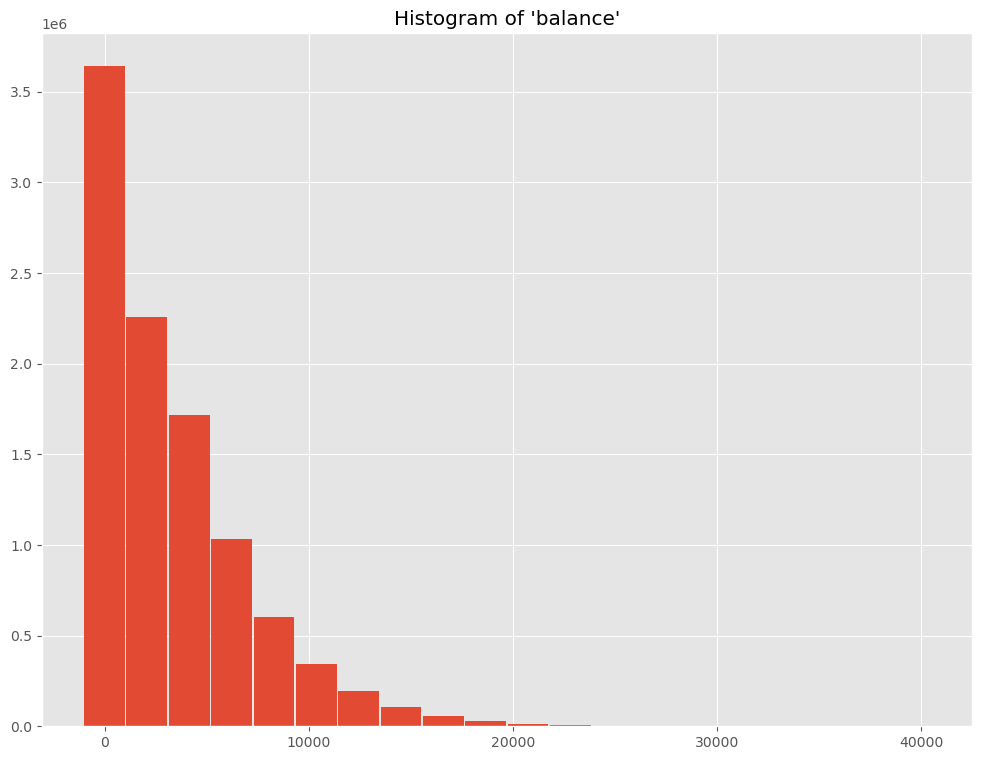

In [35]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

plt.savefig('B05793_05_22.png', dpi=300)

If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the method showed above) you can bring the data and use the .hist(...) (from Matplotlib) or .Histogram(...) (from Bokeh) methods.

In [36]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

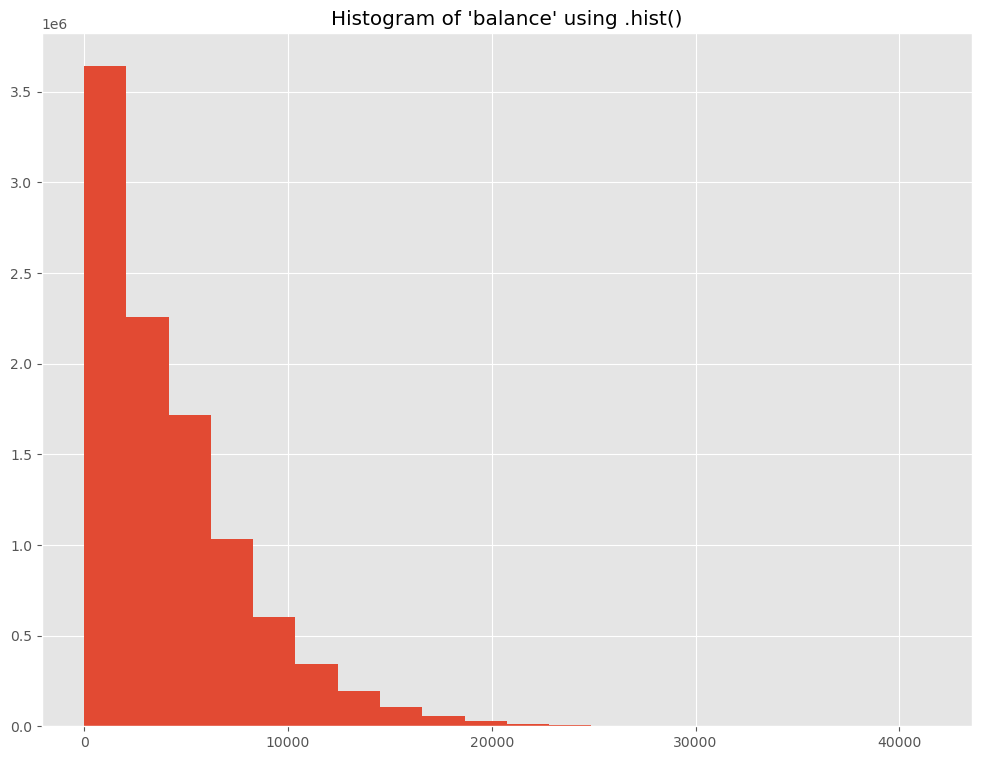

In [47]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


plt.savefig('B05793_05_24.png', dpi=300)